# 07 Classification of anatomical tumour localisation, by hemispheric lobe


Kernel: `glioma-loc-long` on MacOS (--> `segment-glioma` on Ubuntu)

Marianne Hannisdal 

Last updated: **2025-03-13**  

### Import libraries we will use

In [5]:
# Import libraries
import os
import os.path as op
import glob
import shutil
import subprocess as subp
import pathlib
import platform
import shutil
import IPython
from datetime import date
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import nilearn
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pickle
import pydicom
from pydicom import dcmread
# import imageio
import imageio.v2 as imageio

%matplotlib inline
home = os.path.expanduser('~')            # To make a path to local home directory
                       
warnings.filterwarnings('ignore')         # To ignore warnings

In [6]:
print(f'platform: {platform.platform()}')
print(f'python version: {platform.python_version()}')
print(f'pydicom version: {pydicom.__version__}')
print(f'nibabel version: {nib.__version__}')
print(f'nilearn version: {nilearn.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

platform: Linux-6.8.0-45-generic-x86_64-with-glibc2.39
python version: 3.11.9
pydicom version: 2.4.4
nibabel version: 5.2.1
nilearn version: 0.10.4
pandas version: 2.2.2
numpy version: 1.26.4
seaborn version: 0.13.2


In [7]:
verbose = True
SITE = 10
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
    PRJ_DIR = f'{home}/prj/glioma-recurrence'
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
    PRJ_DIR = f"{os.path.expanduser('~')}/prj/glioma_recurrence/glioma_recurrence/data"

RESULTS_overall = f'{PRJ_DIR}/results'
df_total = pd.read_csv(f'{RESULTS_overall}/TOTAL_HD95_clinical_OVL.csv')


OK, you are running on Linux (#45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2)


## Checking that the computed overlapping volumes adds up to the actual segmented volumes

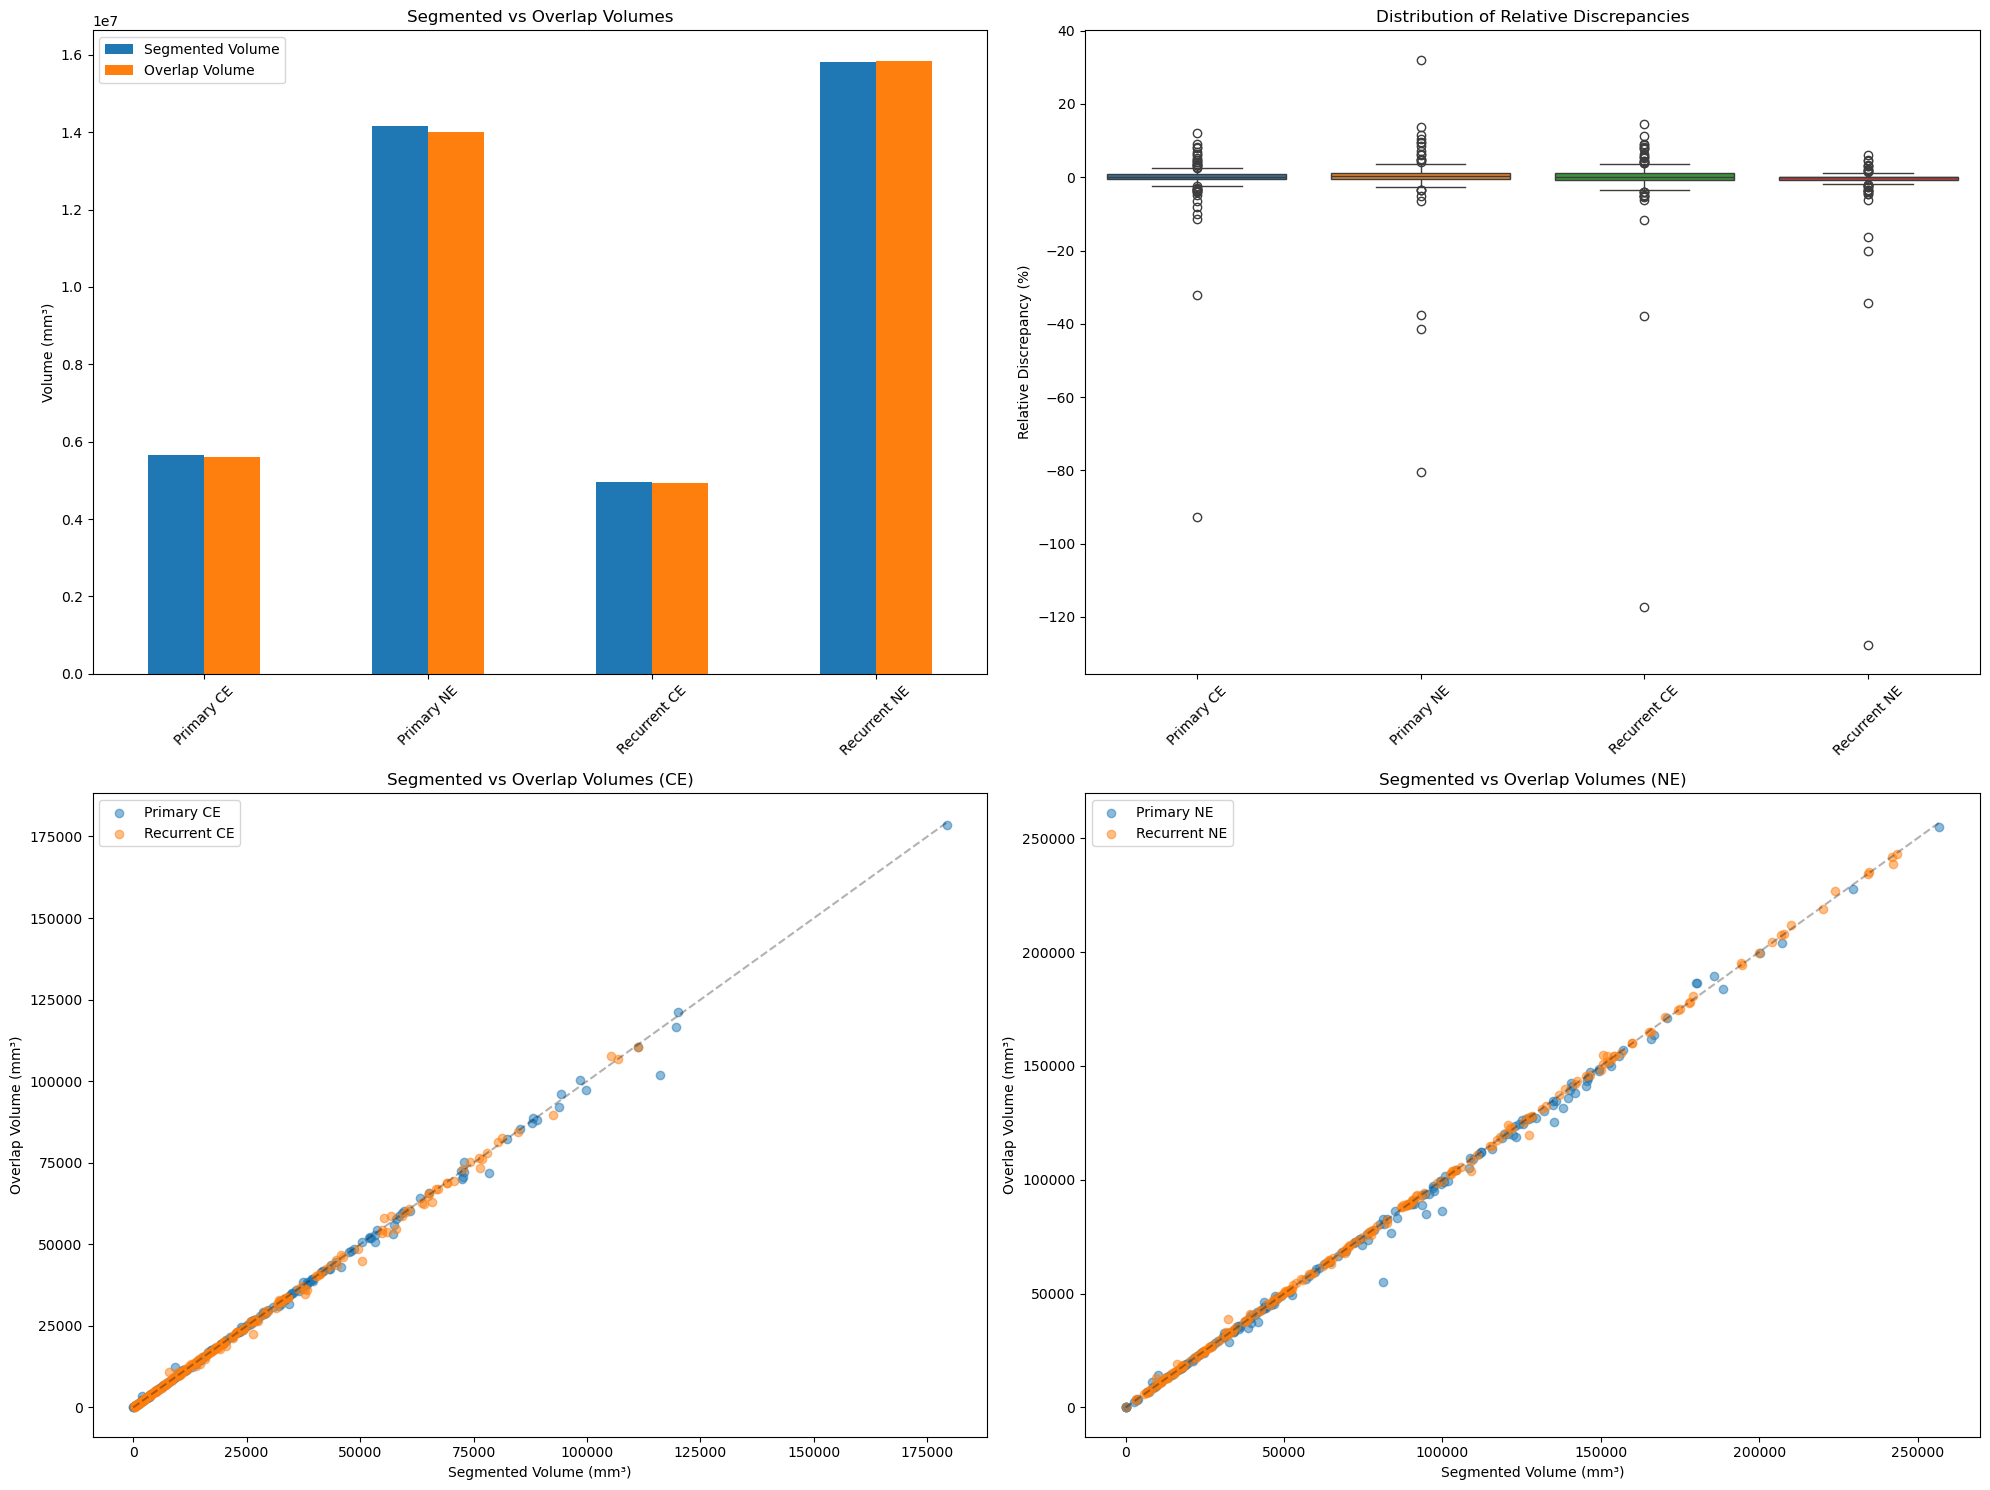

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_volume_discrepancy(df):
    """
    Analyze discrepancies between segmented tumor volumes and sum of regional overlaps
    """
    results = []
    
    # List of all anatomical regions
    regions = ['frontal_left', 'frontal_right',
              'parietal_left', 'parietal_right',
              'temporal_left', 'temporal_right',
              'occipital_left', 'occipital_right',
              'limbic_left', 'limbic_right',
              'subcortical_left', 'subcortical_right',
              'brainstem_and_cerebellum',
              'corpus_callosum',
              'ventricles',
              'central']

    for _, row in df.iterrows():
        # Get segmented volumes
        primary_ce_segmented = row['primary_CE_core_volume']
        primary_ne_segmented = row['primary_NE_volume']
        recurrent_ce_segmented = row['recurrent_CE_core_volume']
        recurrent_ne_segmented = row['recurrent_NE_volume']
        
        # Calculate sum of regional overlaps
        primary_ce_overlap = sum(row[f'OVL_{region}_CE_core_Primary'] for region in regions)
        primary_ne_overlap = sum(row[f'OVL_{region}_NE_Primary'] for region in regions)
        recurrent_ce_overlap = sum(row[f'OVL_{region}_CE_core_Recurrent'] for region in regions)
        recurrent_ne_overlap = sum(row[f'OVL_{region}_NE_Recurrent'] for region in regions)
        
        # Calculate discrepancies
        primary_ce_discrepancy = primary_ce_segmented - primary_ce_overlap
        primary_ne_discrepancy = primary_ne_segmented - primary_ne_overlap
        recurrent_ce_discrepancy = recurrent_ce_segmented - recurrent_ce_overlap
        recurrent_ne_discrepancy = recurrent_ne_segmented - recurrent_ne_overlap
        
        # Calculate relative discrepancies (as percentage of segmented volume)
        primary_ce_relative_discrepancy = (primary_ce_discrepancy / primary_ce_segmented * 100) if primary_ce_segmented != 0 else 0
        primary_ne_relative_discrepancy = (primary_ne_discrepancy / primary_ne_segmented * 100) if primary_ne_segmented != 0 else 0
        recurrent_ce_relative_discrepancy = (recurrent_ce_discrepancy / recurrent_ce_segmented * 100) if recurrent_ce_segmented != 0 else 0
        recurrent_ne_relative_discrepancy = (recurrent_ne_discrepancy / recurrent_ne_segmented * 100) if recurrent_ne_segmented != 0 else 0
        
        results.append({
            'Subject': row['Subject'],
            'Primary_CE_Segmented': primary_ce_segmented,
            'Primary_CE_Overlap': primary_ce_overlap,
            'Primary_CE_Discrepancy': primary_ce_discrepancy,
            'Primary_CE_Relative_Discrepancy': primary_ce_relative_discrepancy,
            'Primary_NE_Segmented': primary_ne_segmented,
            'Primary_NE_Overlap': primary_ne_overlap,
            'Primary_NE_Discrepancy': primary_ne_discrepancy,
            'Primary_NE_Relative_Discrepancy': primary_ne_relative_discrepancy,
            'Recurrent_CE_Segmented': recurrent_ce_segmented,
            'Recurrent_CE_Overlap': recurrent_ce_overlap,
            'Recurrent_CE_Discrepancy': recurrent_ce_discrepancy,
            'Recurrent_CE_Relative_Discrepancy': recurrent_ce_relative_discrepancy,
            'Recurrent_NE_Segmented': recurrent_ne_segmented,
            'Recurrent_NE_Overlap': recurrent_ne_overlap,
            'Recurrent_NE_Discrepancy': recurrent_ne_discrepancy,
            'Recurrent_NE_Relative_Discrepancy': recurrent_ne_relative_discrepancy
        })
    
    return pd.DataFrame(results)

def plot_volume_discrepancies(discrepancy_df):
    """
    Create visualizations for volume discrepancies
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Absolute volume comparison
    plt.subplot(2, 2, 1)
    data_to_plot = pd.DataFrame({
        'Segmented Volume': [discrepancy_df['Primary_CE_Segmented'].sum(),
                           discrepancy_df['Primary_NE_Segmented'].sum(),
                           discrepancy_df['Recurrent_CE_Segmented'].sum(),
                           discrepancy_df['Recurrent_NE_Segmented'].sum()],
        'Overlap Volume': [discrepancy_df['Primary_CE_Overlap'].sum(),
                          discrepancy_df['Primary_NE_Overlap'].sum(),
                          discrepancy_df['Recurrent_CE_Overlap'].sum(),
                          discrepancy_df['Recurrent_NE_Overlap'].sum()]
    }, index=['Primary CE', 'Primary NE', 'Recurrent CE', 'Recurrent NE'])
    
    data_to_plot.plot(kind='bar', ax=plt.gca())
    plt.title('Segmented vs Overlap Volumes')
    plt.ylabel('Volume (mm³)')
    plt.xticks(rotation=45)
    
    # 2. Box plot of relative discrepancies
    plt.subplot(2, 2, 2)
    relative_discrepancies = pd.DataFrame({
        'Primary CE': discrepancy_df['Primary_CE_Relative_Discrepancy'],
        'Primary NE': discrepancy_df['Primary_NE_Relative_Discrepancy'],
        'Recurrent CE': discrepancy_df['Recurrent_CE_Relative_Discrepancy'],
        'Recurrent NE': discrepancy_df['Recurrent_NE_Relative_Discrepancy']
    })
    sns.boxplot(data=relative_discrepancies)
    plt.title('Distribution of Relative Discrepancies')
    plt.ylabel('Relative Discrepancy (%)')
    plt.xticks(rotation=45)
    
    # 3. Scatter plot of segmented vs overlap volumes
    plt.subplot(2, 2, 3)
    plt.scatter(discrepancy_df['Primary_CE_Segmented'], 
               discrepancy_df['Primary_CE_Overlap'], 
               label='Primary CE', alpha=0.5)
    plt.scatter(discrepancy_df['Recurrent_CE_Segmented'], 
               discrepancy_df['Recurrent_CE_Overlap'], 
               label='Recurrent CE', alpha=0.5)
    plt.plot([0, max(discrepancy_df['Primary_CE_Segmented'].max(), 
                     discrepancy_df['Recurrent_CE_Segmented'].max())], 
             [0, max(discrepancy_df['Primary_CE_Segmented'].max(), 
                     discrepancy_df['Recurrent_CE_Segmented'].max())], 
             'k--', alpha=0.3)
    plt.title('Segmented vs Overlap Volumes (CE)')
    plt.xlabel('Segmented Volume (mm³)')
    plt.ylabel('Overlap Volume (mm³)')
    plt.legend()
    
    # 4. Scatter plot for NE volumes
    plt.subplot(2, 2, 4)
    plt.scatter(discrepancy_df['Primary_NE_Segmented'], 
               discrepancy_df['Primary_NE_Overlap'], 
               label='Primary NE', alpha=0.5)
    plt.scatter(discrepancy_df['Recurrent_NE_Segmented'], 
               discrepancy_df['Recurrent_NE_Overlap'], 
               label='Recurrent NE', alpha=0.5)
    plt.plot([0, max(discrepancy_df['Primary_NE_Segmented'].max(), 
                     discrepancy_df['Recurrent_NE_Segmented'].max())], 
             [0, max(discrepancy_df['Primary_NE_Segmented'].max(), 
                     discrepancy_df['Recurrent_NE_Segmented'].max())], 
             'k--', alpha=0.3)
    plt.title('Segmented vs Overlap Volumes (NE)')
    plt.xlabel('Segmented Volume (mm³)')
    plt.ylabel('Overlap Volume (mm³)')
    plt.legend()
    
    plt.tight_layout()
    return fig

# Run the analysis
discrepancy_results = analyze_volume_discrepancy(df_total)

# Create visualizations
fig = plot_volume_discrepancies(discrepancy_results)
plt.show()

# Assign every subject with a primary and recurrent localization

#### First: defining the correct threshold:

The optimal classification thresholds were determined through a data-driven approach using multiple evaluation metrics: silhouette score for cluster separation, entropy score for distribution balance, mean confidence, and high-confidence rate. These metrics were combined into a composite score (weighted 30% silhouette score, 20% entropy score, 30% mean confidence, 20% high-confidence rate), and optimal thresholds were identified by maximizing this composite score across a grid search of junction thresholds (0.15-0.35) and dominant thresholds (0.80-1). This is shown in the below code:


Optimizing thresholds for Primary tumors...


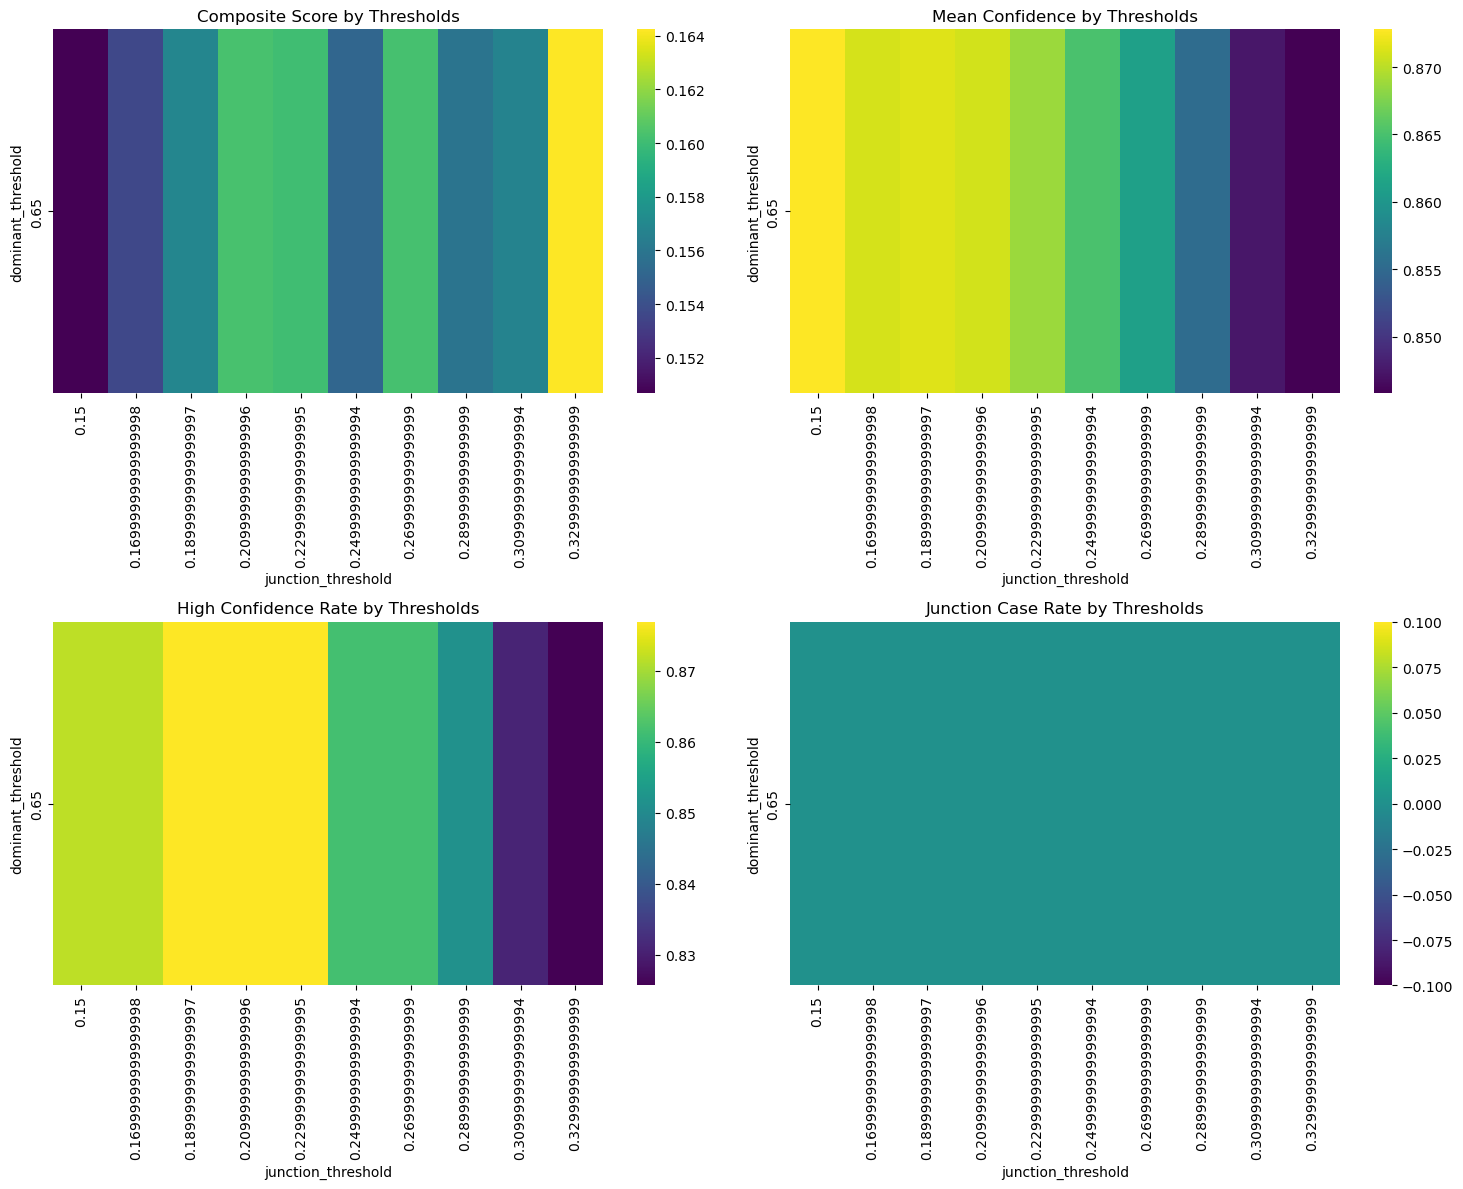


Optimal thresholds for Primary:
Junction threshold: 0.330
Dominant threshold: 0.900

Metrics at optimal thresholds:
silhouette_score: 0.009
entropy_score: 2.259
mean_confidence: 0.847
high_confidence_rate: 0.826
junction_rate: 0.000
Composite score: 0.170

Optimizing thresholds for Recurrent tumors...


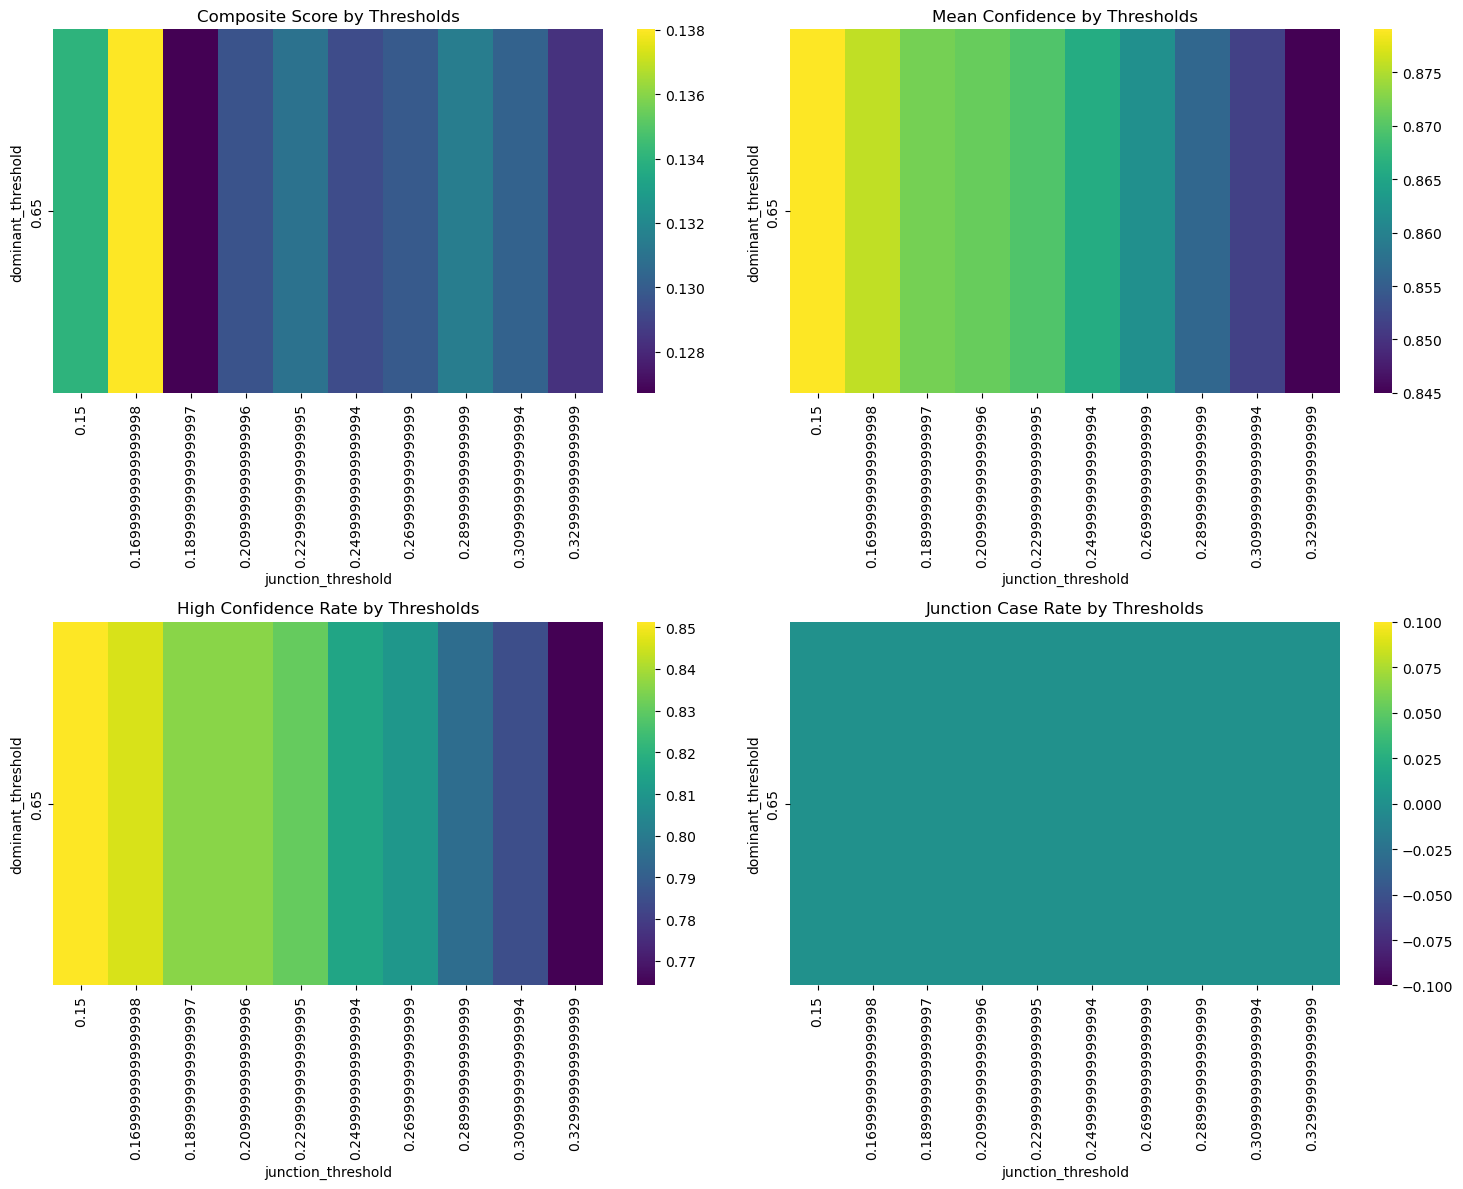


Optimal thresholds for Recurrent:
Junction threshold: 0.170
Dominant threshold: 0.900

Metrics at optimal thresholds:
silhouette_score: -0.058
entropy_score: 2.368
mean_confidence: 0.878
high_confidence_rate: 0.851
junction_rate: 0.000
Composite score: 0.142


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.model_selection import KFold
from typing import Dict, Tuple, List

df = df_total

class ThresholdOptimizer:
    def __init__(self, df: pd.DataFrame, classifier):
        self.df = df
        self.classifier = classifier
        self.basic_lobes = classifier.basic_lobes
        self.junction_definitions = classifier.junction_definitions
        
    def calculate_lobe_proportions(self, tumor_type: str = 'Primary') -> pd.DataFrame:
        """Calculate baseline lobe proportions for all cases"""
        proportions = pd.DataFrame(index=self.df.index)
        
        for lobe in self.basic_lobes:
            left_vol = self.df[f'OVL_{lobe}_left_CE_core_{tumor_type}']
            right_vol = self.df[f'OVL_{lobe}_right_CE_core_{tumor_type}']
            proportions[lobe] = (left_vol + right_vol)
            
        # Handle zero sum rows
        row_sums = proportions.sum(axis=1)
        valid_rows = row_sums > 0
        proportions.loc[valid_rows] = proportions.loc[valid_rows].div(row_sums[valid_rows], axis=0)
        proportions.fillna(0, inplace=True)
        
        return proportions
    
    def evaluate_thresholds(self, junction_thresholds: List[float], 
                          dominant_thresholds: List[float],
                          tumor_type: str = 'Primary') -> pd.DataFrame:
        """Evaluate different threshold combinations using multiple metrics"""
        results = []
        proportions = self.calculate_lobe_proportions(tumor_type)
        
        for j_thresh in junction_thresholds:
            for d_thresh in dominant_thresholds:
                try:
                    # Update classifier thresholds
                    self.classifier.junction_threshold = j_thresh
                    self.classifier.dominant_threshold = d_thresh
                    
                    # Get classifications with current thresholds
                    classifications = self.classifier.classify_locations(tumor_type)
                    
                    # Calculate evaluation metrics
                    metrics = self._calculate_metrics(classifications, proportions)
                    
                    # Calculate composite score
                    composite_score = (
                        metrics['silhouette_score'] * 0.3 +
                        (1 - metrics['entropy_score']) * 0.2 +
                        metrics['mean_confidence'] * 0.3 +
                        metrics['high_confidence_rate'] * 0.2
                    )
                    
                    results.append({
                        'junction_threshold': j_thresh,
                        'dominant_threshold': d_thresh,
                        'composite_score': composite_score,
                        **metrics
                    })
                    
                except Exception as e:
                    print(f"Error evaluating thresholds {j_thresh}, {d_thresh}: {str(e)}")
                    continue
                
        return pd.DataFrame(results)
    
    def _calculate_metrics(self, classifications: Dict, proportions: pd.DataFrame) -> Dict:
        """Calculate multiple evaluation metrics for given thresholds"""
        try:
            class_series = classifications['classifications']
            conf_scores = classifications['confidence_scores']
            
            # Handle empty or invalid classifications
            if len(class_series) == 0:
                return {
                    'silhouette_score': 0,
                    'entropy_score': 0,
                    'mean_confidence': 0,
                    'high_confidence_rate': 0,
                    'junction_rate': 0
                }
            
            # 1. Silhouette Score for cluster separation
            X = proportions.values
            labels = pd.Categorical(class_series).codes
            sil_score = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else 0
            
            # 2. Classification Entropy
            class_counts = class_series.value_counts(normalize=True)
            entropy_score = entropy(class_counts)
            
            # 3. Mean Confidence Score
            mean_conf = conf_scores.mean()
            
            # 4. High Confidence Rate
            high_conf_rate = (conf_scores >= 0.7).mean()
            
            # 5. Junction Case Rate
            junction_rate = class_series.isin(self.junction_definitions.keys()).mean()
            
            return {
                'silhouette_score': sil_score,
                'entropy_score': entropy_score,
                'mean_confidence': mean_conf,
                'high_confidence_rate': high_conf_rate,
                'junction_rate': junction_rate
            }
            
        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
            return {
                'silhouette_score': 0,
                'entropy_score': 0,
                'mean_confidence': 0,
                'high_confidence_rate': 0,
                'junction_rate': 0
            }
    
    def find_optimal_thresholds(self, tumor_type: str = 'Primary') -> Dict:
        """Find optimal thresholds using grid search"""
        # Define threshold ranges
        junction_thresholds = np.arange(0.15, 0.35, 0.02)
        dominant_thresholds = np.arange(0.85, 1, 0.6)
        
        # Evaluate all combinations
        results_df = self.evaluate_thresholds(junction_thresholds, dominant_thresholds, tumor_type)
        
        if len(results_df) == 0:
            raise ValueError("No valid threshold combinations found")
        
        # Find optimal thresholds
        optimal_row = results_df.loc[results_df['composite_score'].idxmax()]
        
        return {
            'optimal_junction_threshold': optimal_row['junction_threshold'],
            'optimal_dominant_threshold': optimal_row['dominant_threshold'],
            'metrics': {col: optimal_row[col] for col in ['silhouette_score', 'entropy_score', 
                                                         'mean_confidence', 'high_confidence_rate',
                                                         'junction_rate']},
            'composite_score': optimal_row['composite_score']
        }
    
    def plot_threshold_analysis(self, results_df: pd.DataFrame) -> None:
        """Create visualization of threshold analysis"""
        if len(results_df) == 0:
            print("No results to plot")
            return
            
        try:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            
            # Plot composite score heatmap
            pivot_composite = results_df.pivot(index='dominant_threshold', 
                                             columns='junction_threshold',
                                             values='composite_score')
            sns.heatmap(pivot_composite, ax=axes[0,0], cmap='viridis')
            axes[0,0].set_title('Composite Score by Thresholds')
            
            # Plot confidence score heatmap
            pivot_conf = results_df.pivot(index='dominant_threshold',
                                        columns='junction_threshold',
                                        values='mean_confidence')
            sns.heatmap(pivot_conf, ax=axes[0,1], cmap='viridis')
            axes[0,1].set_title('Mean Confidence by Thresholds')
            
            # Plot high confidence rate
            pivot_high_conf = results_df.pivot(index='dominant_threshold',
                                             columns='junction_threshold',
                                             values='high_confidence_rate')
            sns.heatmap(pivot_high_conf, ax=axes[1,0], cmap='viridis')
            axes[1,0].set_title('High Confidence Rate by Thresholds')
            
            # Plot junction case rate
            pivot_junction = results_df.pivot(index='dominant_threshold',
                                            columns='junction_threshold',
                                            values='junction_rate')
            sns.heatmap(pivot_junction, ax=axes[1,1], cmap='viridis')
            axes[1,1].set_title('Junction Case Rate by Thresholds')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error plotting threshold analysis: {str(e)}")

def optimize_thresholds(df: pd.DataFrame, classifier) -> Dict:
    """Run complete threshold optimization analysis"""
    try:
        optimizer = ThresholdOptimizer(df, classifier)
        
        results = {}
        for tumor_type in ['Primary', 'Recurrent']:
            print(f"\nOptimizing thresholds for {tumor_type} tumors...")
            
            # Find optimal thresholds
            optimal = optimizer.find_optimal_thresholds(tumor_type)
            
            # Evaluate range of thresholds
            junction_thresholds = np.arange(0.15, 0.35, 0.02)
            dominant_thresholds = np.arange(0.65, 0.95, 0.5)
            evaluation_results = optimizer.evaluate_thresholds(junction_thresholds, 
                                                             dominant_thresholds,
                                                             tumor_type)
            
            # Plot results
            optimizer.plot_threshold_analysis(evaluation_results)
            
            results[tumor_type.lower()] = {
                'optimal_thresholds': optimal,
                'evaluation_results': evaluation_results
            }
            
            print(f"\nOptimal thresholds for {tumor_type}:")
            print(f"Junction threshold: {optimal['optimal_junction_threshold']:.3f}")
            print(f"Dominant threshold: {optimal['optimal_dominant_threshold']:.3f}")
            print("\nMetrics at optimal thresholds:")
            for metric, value in optimal['metrics'].items():
                print(f"{metric}: {value:.3f}")
            print(f"Composite score: {optimal['composite_score']:.3f}")
        
        return results
    
    except Exception as e:
        print(f"Error in threshold optimization: {str(e)}")
        return None
    
# Initialize your classifier first
classifier = EnhancedTumorLocationClassifier(df)

# Run the optimization
optimization_results = optimize_thresholds(df, classifier)

# Access results
if optimization_results:
    primary_optimal = optimization_results['primary']['optimal_thresholds']

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.model_selection import KFold
from typing import Dict, Tuple, List

In [17]:
class EnhancedTumorLocationClassifier:
    def __init__(self, df: pd.DataFrame) -> None:
        """
        Initialize the tumor location classifier
        
        Args:
            df (pd.DataFrame): DataFrame containing tumor volume data
        """
        self.df = df.copy()
        self.basic_lobes = ['frontal', 'parietal', 'temporal', 'occipital']
        self.brainstem_key = 'brainstem/cerebellum'
        self.brainstem_column = 'brainstem_and_cerebellum'
        self.all_regions = self.basic_lobes + [self.brainstem_key]
        self.hemispheres = ['left', 'right']
        
        # Define junction regions
        self.junction_definitions = {
            'temporo_parietal': ['temporal', 'parietal'],
            'fronto_parietal': ['frontal', 'parietal']
        }
        
        # Thresholds for classification
        self.junction_threshold = 0.24
        self.dominant_threshold = 0.90
        self.hemisphere_threshold = 0.90

    def get_brainstem_volume(self, row: pd.Series, tumor_type: str) -> float:
        """Calculate total brainstem volume regardless of hemisphere"""
        return row[f'OVL_{self.brainstem_column}_CE_core_{tumor_type}']

    def determine_dominant_hemisphere(self, row: pd.Series, tumor_type: str) -> str:
        """
        Determine the dominant hemisphere based on total volume across all lobes
        Returns 'Left', 'Right', or 'bilateral'
        """
        total_left = 0
        total_right = 0
        
        # Sum volumes across all lobes (excluding brainstem)
        for lobe in self.basic_lobes:
            left_vol = row[f'OVL_{lobe}_left_CE_core_{tumor_type}']
            right_vol = row[f'OVL_{lobe}_right_CE_core_{tumor_type}']
            total_left += left_vol
            total_right += right_vol
        
        total = total_left + total_right
        if total == 0:
            return 'bilateral'
                
        left_prop = total_left / total
        right_prop = total_right / total
        
        # Use hemisphere_threshold to determine dominance
        if left_prop >= self.hemisphere_threshold:
            return 'Left'
        elif right_prop >= self.hemisphere_threshold:
            return 'Right'
        else:
            return 'bilateral'
        
    def calculate_lobe_proportions_by_hemisphere(self, row: pd.Series, hemisphere: str, tumor_type: str) -> pd.Series:
        """Calculate the proportion of tumor volume in each lobe for a specific hemisphere"""
        proportions = pd.Series(index=self.basic_lobes, dtype=float)
        
        total_volume = 0
        volumes = {}
        
        # Calculate volumes for each lobe in the specified hemisphere
        for lobe in self.basic_lobes:
            volume = row[f'OVL_{lobe}_{hemisphere.lower()}_CE_core_{tumor_type}']
            volumes[lobe] = volume
            total_volume += volume
        
        # Convert to proportions
        if total_volume > 0:
            for lobe in self.basic_lobes:
                proportions[lobe] = volumes[lobe] / total_volume
                
        return proportions

    def classify_hemisphere_lobes(self, row: pd.Series, hemisphere: str, tumor_type: str) -> Tuple[str, float]:
        """
        Classify lobe involvement for a given hemisphere
        Returns (classification, confidence_score)
        """
        proportions = self.calculate_lobe_proportions_by_hemisphere(row, hemisphere, tumor_type)
        
        # Check for dominant lobe
        max_proportion = proportions.max()
        dominant_lobe = proportions.idxmax()
        
        # Check for junction patterns
        for junction_name, lobes in self.junction_definitions.items():
            if all(proportions[lobe] >= self.junction_threshold for lobe in lobes):
                junction_proportion = sum(proportions[lobe] for lobe in lobes)
                return f"{hemisphere}_{junction_name}", junction_proportion
        
        # If no junction pattern, return the dominant lobe (even if below dominant_threshold)
        return f"{hemisphere}_{dominant_lobe}", max_proportion

    def identify_classifications(self, tumor_type: str) -> Tuple[pd.Series, pd.Series, pd.DataFrame]:
        """Identify final classifications including hemisphere and lobe involvement"""
        classifications = pd.Series(index=self.df.index, dtype=str)
        confidence_scores = pd.Series(index=self.df.index, dtype=float)
        detailed_proportions = pd.DataFrame(index=self.df.index)
        
        for idx in self.df.index:
            row = self.df.loc[idx]
            
            # First check for brainstem predominance
            brainstem_vol = self.get_brainstem_volume(row, tumor_type)
            total_vol = sum(row[f'OVL_{lobe}_{hemi}_CE_core_{tumor_type}'] 
                          for lobe in self.basic_lobes 
                          for hemi in ['left', 'right']) + brainstem_vol
            
            if total_vol > 0:
                brainstem_prop = brainstem_vol / total_vol
                if brainstem_prop >= self.dominant_threshold:
                    classifications[idx] = self.brainstem_key
                    confidence_scores[idx] = brainstem_prop
                    detailed_proportions.loc[idx, 'primary_lobe'] = self.brainstem_key
                    detailed_proportions.loc[idx, 'primary_proportion'] = brainstem_prop
                    detailed_proportions.loc[idx, 'hemisphere'] = 'bilateral'
                    continue
            
            # Determine hemisphere
            hemisphere = self.determine_dominant_hemisphere(row, tumor_type)
            detailed_proportions.loc[idx, 'hemisphere'] = hemisphere
            
            # For bilateral cases, stop here
            if hemisphere == 'bilateral':
                classifications[idx] = 'midline/bilateral'
                confidence_scores[idx] = 0.5  # Default confidence for bilateral cases
                detailed_proportions.loc[idx, 'primary_lobe'] = 'midline/bilateral'
                continue
            
            # For unilateral cases, classify lobe involvement
            classification, confidence = self.classify_hemisphere_lobes(row, hemisphere, tumor_type)
            classifications[idx] = classification
            confidence_scores[idx] = confidence
            
            # Store detailed proportions
            proportions = self.calculate_lobe_proportions_by_hemisphere(row, hemisphere, tumor_type)
            sorted_props = proportions.sort_values(ascending=False)
            detailed_proportions.loc[idx, 'primary_lobe'] = sorted_props.index[0]
            detailed_proportions.loc[idx, 'primary_proportion'] = sorted_props.iloc[0]
            detailed_proportions.loc[idx, 'secondary_lobe'] = sorted_props.index[1]
            detailed_proportions.loc[idx, 'secondary_proportion'] = sorted_props.iloc[1]
        
        return classifications, confidence_scores, detailed_proportions

    def classify_locations(self, tumor_type: str = 'Primary') -> Dict:
        """Classify tumor locations with strict hemisphere-first approach"""
        classifications, confidence_scores, detailed_props = self.identify_classifications(tumor_type)
        
        validation_results = self.validate_classifications(classifications, detailed_props, tumor_type)
        
        results = {
            'classifications': classifications,
            'confidence_scores': confidence_scores,
            'detailed_proportions': detailed_props,
            'validation_results': validation_results
        }
        
        return results

    def validate_classifications(self, classifications: pd.Series, detailed_props: pd.DataFrame, tumor_type: str) -> pd.DataFrame:
        """Validate hemisphere classifications by comparing with raw volume data"""
        validation = pd.DataFrame(index=classifications.index)
        
        for idx in classifications.index:
            row = self.df.loc[idx]
            assigned_hemisphere = detailed_props.loc[idx, 'hemisphere']
            
            # Skip validation for bilateral and brainstem cases
            if assigned_hemisphere in ['bilateral', 'midline']:
                continue
            
            # Calculate hemisphere totals (excluding brainstem)
            left_total = sum(row[f'OVL_{lobe}_left_CE_core_{tumor_type}'] for lobe in self.basic_lobes)
            right_total = sum(row[f'OVL_{lobe}_right_CE_core_{tumor_type}'] for lobe in self.basic_lobes)
            
            total = left_total + right_total
            if total > 0:
                left_ratio = left_total / total
                right_ratio = right_total / total
                
                validation.loc[idx, 'left_ratio'] = left_ratio
                validation.loc[idx, 'right_ratio'] = right_ratio
                validation.loc[idx, 'assigned_hemisphere'] = assigned_hemisphere
                validation.loc[idx, 'volume_based_hemisphere'] = 'Left' if left_ratio > right_ratio else 'Right'
                validation.loc[idx, 'potential_mismatch'] = assigned_hemisphere != validation.loc[idx, 'volume_based_hemisphere']
                validation.loc[idx, 'confidence'] = max(left_ratio, right_ratio)
        
        return validation

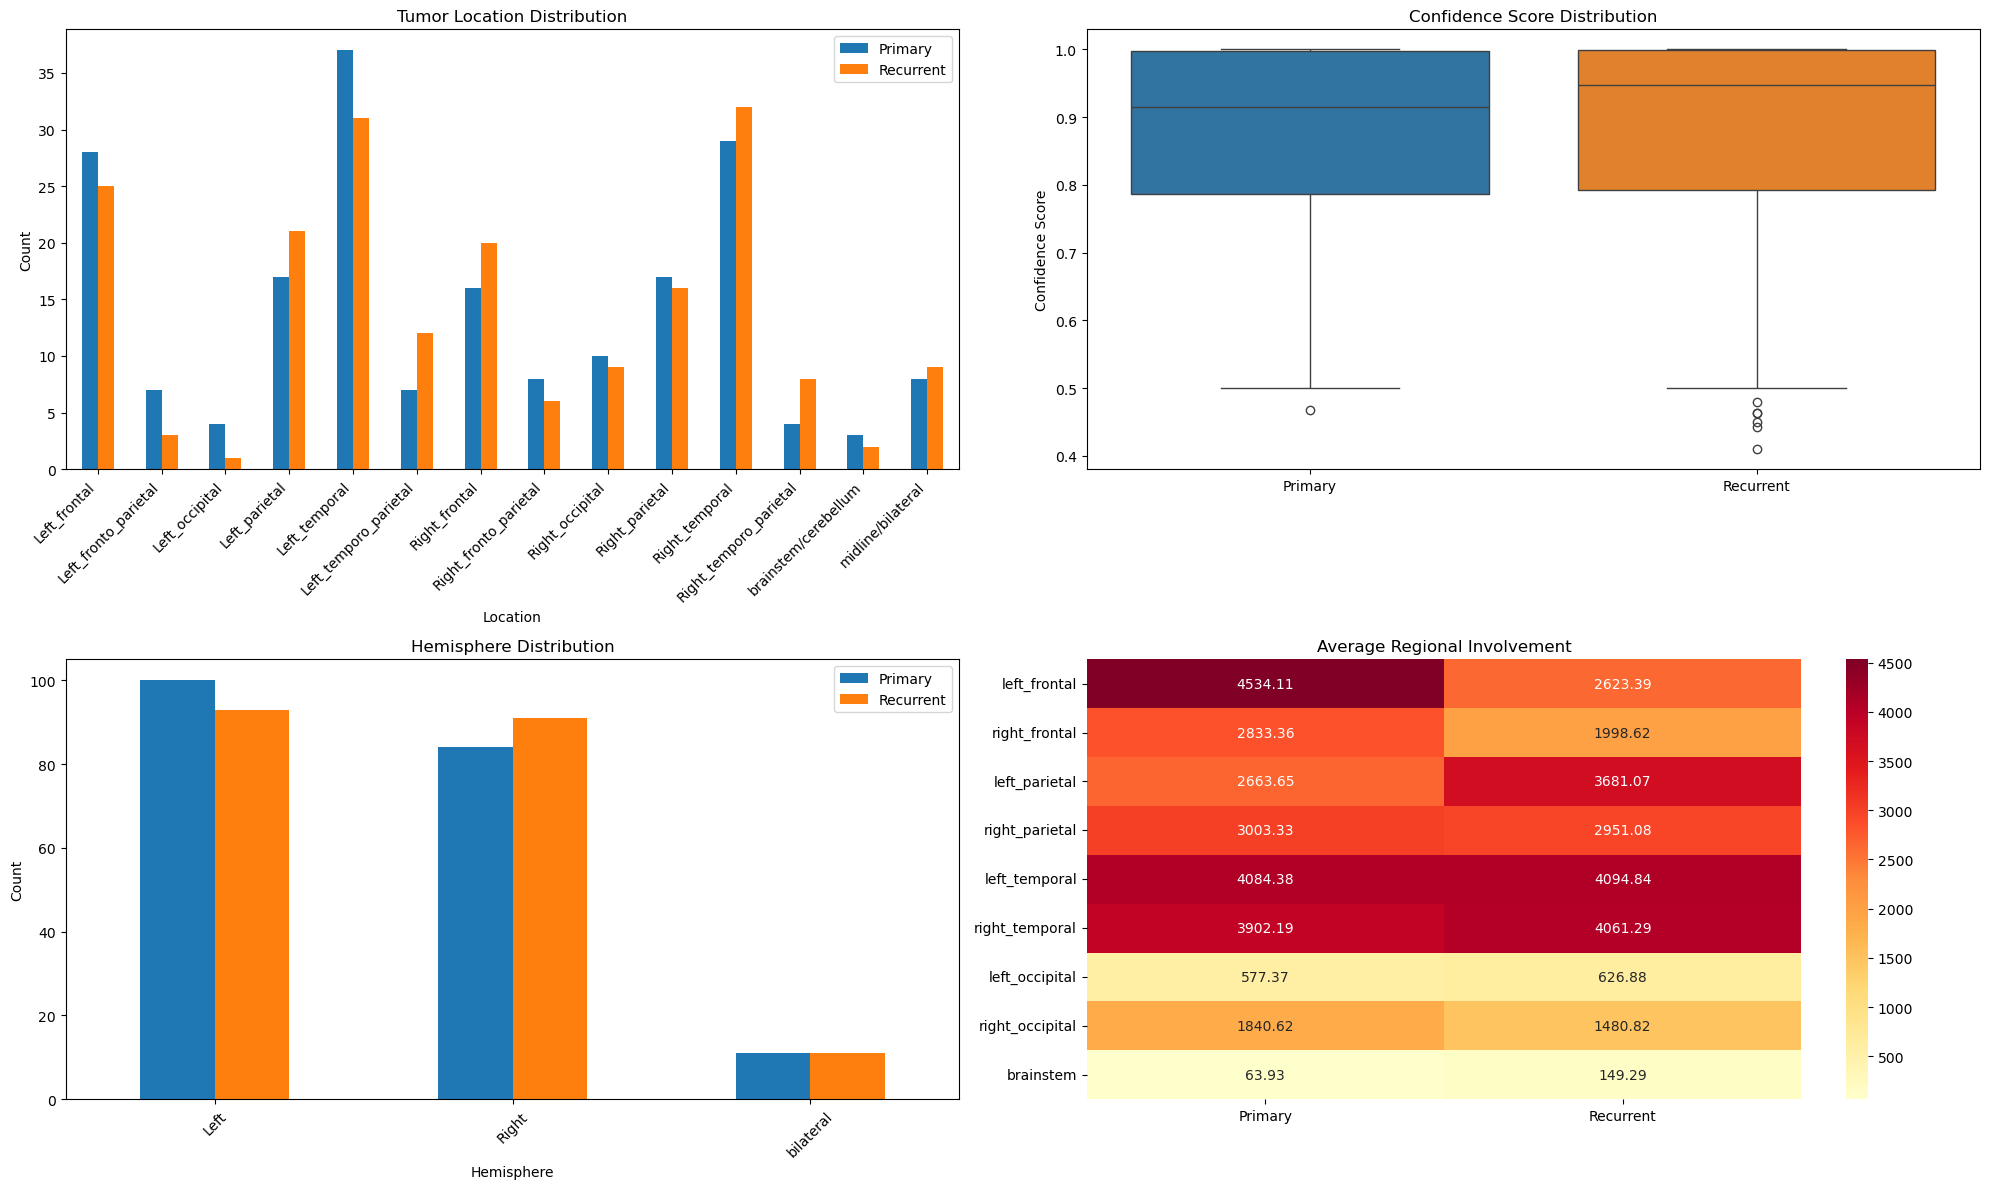

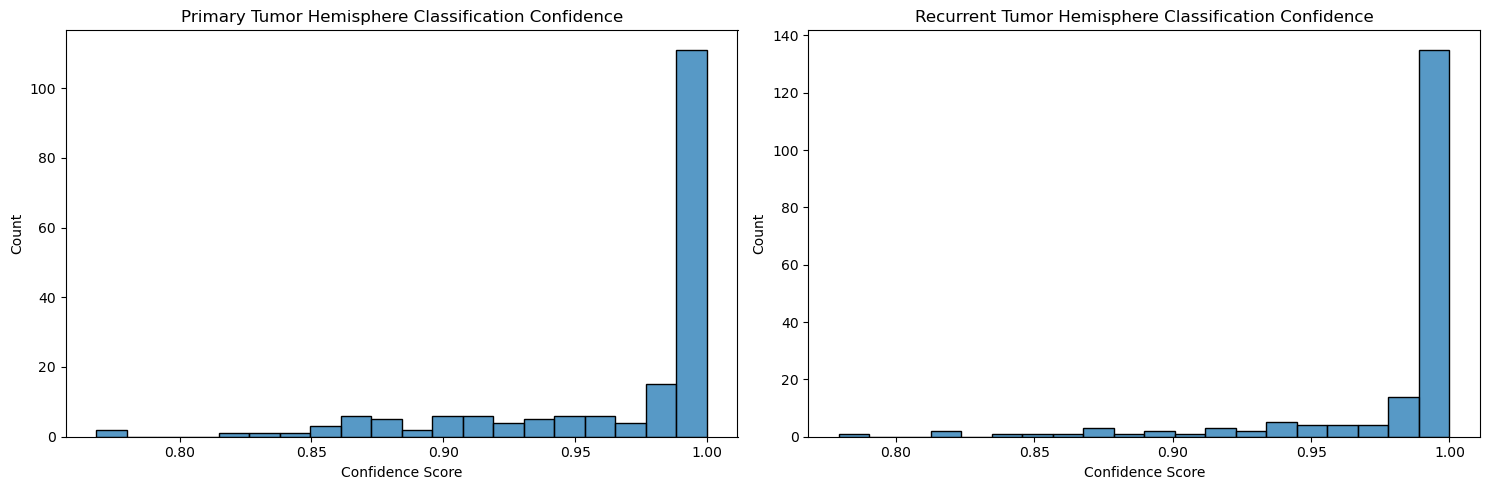


=== Primary Tumor Classification Summary ===

Location Distribution:
Left_temporal: 37 (19.0%)
Right_temporal: 29 (14.9%)
Left_frontal: 28 (14.4%)
Left_parietal: 17 (8.7%)
Right_parietal: 17 (8.7%)
Right_frontal: 16 (8.2%)
Right_occipital: 10 (5.1%)
Right_fronto_parietal: 8 (4.1%)
midline/bilateral: 8 (4.1%)
Left_temporo_parietal: 7 (3.6%)
Left_fronto_parietal: 7 (3.6%)
Left_occipital: 4 (2.1%)
Right_temporo_parietal: 4 (2.1%)
brainstem/cerebellum: 3 (1.5%)

Hemisphere Distribution:
Left: 100 (51.3%)
Right: 84 (43.1%)
bilateral: 11 (5.6%)

Confidence Analysis:
Median confidence score: 0.92
High confidence rate: 87.2%

Confidence Distribution:
Very High: 79.5%
High: 15.9%
Moderate: 4.6%
Low: 0.0%

=== Recurrent Tumor Classification Summary ===

Location Distribution:
Right_temporal: 32 (16.4%)
Left_temporal: 31 (15.9%)
Left_frontal: 25 (12.8%)
Left_parietal: 21 (10.8%)
Right_frontal: 20 (10.3%)
Right_parietal: 16 (8.2%)
Left_temporo_parietal: 12 (6.2%)
midline/bilateral: 9 (4.6%)
Right

In [14]:
def analyze_confidence_distribution(results: dict) -> dict:
    """Analyze the distribution of confidence scores"""
    confidence_scores = results['confidence_scores']
    
    confidence_analysis = {
        'median_confidence': confidence_scores.median(),
        'high_confidence_rate': (confidence_scores >= 0.7).mean(),
        'confidence_distribution': pd.cut(confidence_scores, 
                                       bins=[0, 0.25, 0.5, 0.75, 1.0],
                                       labels=['Low', 'Moderate', 'High', 'Very High']
                                       ).value_counts(normalize=True)
    }
    
    return confidence_analysis

def calculate_mean_proportions(df: pd.DataFrame, tumor_type: str) -> pd.Series:
    """Calculate mean proportions for each lobe and hemisphere"""
    basic_lobes = ['frontal', 'parietal', 'temporal', 'occipital']
    hemispheres = ['left', 'right']
    proportions = {}
    
    # Calculate proportions for each combination
    for lobe in basic_lobes:
        for hemi in hemispheres:
            col = f'OVL_{lobe}_{hemi}_CE_core_{tumor_type}'
            proportions[f'{hemi}_{lobe}'] = df[col].mean()
    
    # Add brainstem
    proportions['brainstem'] = df[f'OVL_brainstem_and_cerebellum_CE_core_{tumor_type}'].mean()
    
    return pd.Series(proportions)

def plot_classification_results(primary_results: dict, recurrent_results: dict, df: pd.DataFrame):
    """Create visualizations comparing primary and recurrent tumor classifications"""
    # Add confidence analysis to results
    primary_results['confidence_analysis'] = analyze_confidence_distribution(primary_results)
    recurrent_results['confidence_analysis'] = analyze_confidence_distribution(recurrent_results)
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Location Distribution Comparison
    plt.subplot(2, 2, 1)
    location_counts = pd.DataFrame({
        'Primary': primary_results['classifications'].value_counts(),
        'Recurrent': recurrent_results['classifications'].value_counts()
    }).fillna(0)
    
    location_counts.plot(kind='bar', ax=plt.gca())
    plt.title('Tumor Location Distribution')
    plt.xlabel('Location')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # 2. Confidence Score Distribution
    plt.subplot(2, 2, 2)
    confidence_data = pd.DataFrame({
        'Primary': primary_results['confidence_scores'],
        'Recurrent': recurrent_results['confidence_scores']
    })
    
    sns.boxplot(data=confidence_data)
    plt.title('Confidence Score Distribution')
    plt.ylabel('Confidence Score')
    
    # 3. Hemisphere Distribution
    plt.subplot(2, 2, 3)
    primary_hemispheres = primary_results['detailed_proportions']['hemisphere'].value_counts()
    recurrent_hemispheres = recurrent_results['detailed_proportions']['hemisphere'].value_counts()
    
    hemisphere_counts = pd.DataFrame({
        'Primary': primary_hemispheres,
        'Recurrent': recurrent_hemispheres
    }).fillna(0)
    
    hemisphere_counts.plot(kind='bar', ax=plt.gca())
    plt.title('Hemisphere Distribution')
    plt.xlabel('Hemisphere')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # 4. Heatmap of Mean Proportions (Primary vs Recurrent)
    plt.subplot(2, 2, 4)
    mean_proportions = pd.DataFrame({
        'Primary': calculate_mean_proportions(df, 'Primary'),
        'Recurrent': calculate_mean_proportions(df, 'Recurrent')
    })
    
    sns.heatmap(mean_proportions, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Average Regional Involvement')
    
    plt.tight_layout()
    plt.show()
    
    # Additional validation visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Primary tumor hemisphere confidence
    primary_validation = primary_results['validation_results'].dropna(subset=['confidence'])
    sns.histplot(data=primary_validation, x='confidence', bins=20, ax=ax1)
    ax1.set_title('Primary Tumor Hemisphere Classification Confidence')
    ax1.set_xlabel('Confidence Score')
    
    # Recurrent tumor hemisphere confidence
    recurrent_validation = recurrent_results['validation_results'].dropna(subset=['confidence'])
    sns.histplot(data=recurrent_validation, x='confidence', bins=20, ax=ax2)
    ax2.set_title('Recurrent Tumor Hemisphere Classification Confidence')
    ax2.set_xlabel('Confidence Score')
    
    plt.tight_layout()
    plt.show()

def print_classification_summary(results: dict, tumor_type: str):
    """Print a summary of the classification results"""
    print(f"\n=== {tumor_type} Tumor Classification Summary ===")
    
    # Location distribution
    print("\nLocation Distribution:")
    location_counts = results['classifications'].value_counts()
    for location, count in location_counts.items():
        print(f"{location}: {count} ({count/len(results['classifications'])*100:.1f}%)")
    
    # Hemisphere distribution
    print("\nHemisphere Distribution:")
    hemisphere_counts = results['detailed_proportions']['hemisphere'].value_counts()
    for hemisphere, count in hemisphere_counts.items():
        print(f"{hemisphere}: {count} ({count/len(results['detailed_proportions'])*100:.1f}%)")
    
    # Confidence analysis
    print("\nConfidence Analysis:")
    conf_analysis = analyze_confidence_distribution(results)
    print(f"Median confidence score: {conf_analysis['median_confidence']:.2f}")
    print(f"High confidence rate: {conf_analysis['high_confidence_rate']*100:.1f}%")
    print("\nConfidence Distribution:")
    for level, proportion in conf_analysis['confidence_distribution'].items():
        print(f"{level}: {proportion*100:.1f}%")

def run_complete_analysis(df: pd.DataFrame) -> Dict:
    """Run complete analysis for both primary and recurrent tumors"""
    classifier = EnhancedTumorLocationClassifier(df)
    
    # Analyze both tumor types
    results = {}
    for tumor_type in ['Primary', 'Recurrent']:
        results[tumor_type.lower()] = classifier.classify_locations(tumor_type)
    
    # Create visualizations
    plot_classification_results(results['primary'], results['recurrent'], df)
    
    # Print summaries
    for tumor_type in ['Primary', 'Recurrent']:
        print_classification_summary(results[tumor_type.lower()], tumor_type)
    
    return results

results = run_complete_analysis(df_total)

## Writing the classified anatomical localizations to the df

In [20]:
def display_tumor_locations_by_subject(df_total: pd.DataFrame, results: Dict) -> pd.DataFrame:
    """
    Display a summary of primary and recurrent tumor locations for each subject
    and return a DataFrame with the results. Only displays first 20 patients.
    
    Args:
        df_total: DataFrame containing the Subject column
        results: Dictionary containing classification results
        
    Returns:
        pd.DataFrame: Summary DataFrame with tumor locations and confidence scores
    """
    # Create base DataFrame
    summary_df = pd.DataFrame({
        'Subject': df_total['Subject'],
        'Primary_Location': results['primary']['classifications'],
        'Primary_Confidence': results['primary']['confidence_scores'].round(3),
        'Recurrent_Location': results['recurrent']['classifications'],
        'Recurrent_Confidence': results['recurrent']['confidence_scores'].round(3)
    })
    
    # The new classifier already includes hemisphere information in classifications,
    # so we just need to copy these values
    summary_df['Primary_Full_Location'] = summary_df['Primary_Location']
    summary_df['Recurrent_Full_Location'] = summary_df['Recurrent_Location']
    
    # Sort by Subject ID
    summary_df = summary_df.sort_values('Subject')
    
    # Print summary table
    print("\nTumor Location Summary by Subject")
    print("="*100)
    print(f"{'Patient #':<15} {'Primary Location':<25} {'Conf.':<7} {'Recurrent Location':<25} {'Conf.':<7}")
    print("-"*100)
    
    # Print each subject's information with numbered index instead of Subject ID
    # Limit to first 20 rows
    for i, (_, row) in enumerate(summary_df.iterrows(), 1):
        if i > 20:  # Only show first 20 rows
            break
        print(f"Patient {i:<9} {row['Primary_Full_Location']:<25} {row['Primary_Confidence']:<7.3f} "
              f"{row['Recurrent_Full_Location']:<25} {row['Recurrent_Confidence']:<7.3f}")
    
    # Add a note about limited display if there are more than 20 subjects
    if len(summary_df) > 20:
        print("-"*100)
        print(f"Note: Showing 20 of {len(summary_df)} total patients")
    
    print("="*100)
    print("Note: Confidence scores range from 0 to 1, where higher values indicate greater certainty")
    print("Note: 'midline/bilateral' indicates tumor presence in both hemispheres")
    print("Note: 'brainstem/cerebellum' indicates tumor in brainstem/cerebellum region")
    
    return summary_df

# To use:
# Create classifier instance
classifier = EnhancedTumorLocationClassifier(df_total)

# Get classifications for both tumor types
results = {
    'primary': classifier.classify_locations('Primary'),
    'recurrent': classifier.classify_locations('Recurrent')
}

# Display and get summary DataFrame
summary_df = display_tumor_locations_by_subject(df_total, results)


Tumor Location Summary by Subject
Patient #       Primary Location          Conf.   Recurrent Location        Conf.  
----------------------------------------------------------------------------------------------------
Patient 1         Left_temporal             0.945   midline/bilateral         0.500  
Patient 2         Left_temporal             0.982   Left_temporal             0.934  
Patient 3         Left_frontal              0.977   midline/bilateral         0.500  
Patient 4         Right_fronto_parietal     0.942   Right_temporo_parietal    0.897  
Patient 5         Left_frontal              0.789   Left_frontal              0.737  
Patient 6         Left_temporal             0.915   Left_temporo_parietal     1.000  
Patient 7         Left_temporal             0.843   Left_temporal             0.862  
Patient 8         Left_temporal             0.924   Left_temporal             0.991  
Patient 9         Left_parietal             0.900   Left_parietal             0.933  
Patien

## Saving to CSV

In [21]:
def save_tumor_locations(results: Dict, df_total: pd.DataFrame, save_path: str) -> None:
    """
    Save tumor locations and confidence scores to CSV file, using subject IDs from df_total.
    
    Args:
        results: Dictionary containing classification results
        df_total: Original dataframe containing correct Subject IDs
        save_path: Path to the RESULTS_overall directory
    """
    # Create DataFrame with results, using Subject from df_total
    summary_df = pd.DataFrame({
        'Subject': df_total['Subject'],
        'class_primary_location': results['primary']['classifications'],
        'conf_primary': results['primary']['confidence_scores'].round(3),
        'class_recurrent_location': results['recurrent']['classifications'],
        'conf_recurrent': results['recurrent']['confidence_scores'].round(3)
    })
    
    # Verify that indices match
    if not all(summary_df.index == df_total.index):
        raise ValueError("Index mismatch between results and df_total. Data integrity cannot be guaranteed.")

    
    # Double-check Subject alignment
    print("\nVerifying Subject alignment:")
    mismatches = (summary_df['Subject'] != df_total['Subject'])
    if mismatches.any():
        print("WARNING: Subject misalignment detected!")
        print("Mismatched rows:")
        print(pd.DataFrame({
            'Summary_Subject': summary_df.loc[mismatches, 'Subject'],
            'Original_Subject': df_total.loc[mismatches, 'Subject']
        }))
        raise ValueError("Subject mismatch detected. Please check data alignment.")
    else:
        print("Subject alignment verified ✓")
    
    # Add detailed proportions if needed
    summary_df['primary_hemisphere'] = results['primary']['detailed_proportions']['hemisphere']
    summary_df['recurrent_hemisphere'] = results['recurrent']['detailed_proportions']['hemisphere']
    
    # Add validation metrics
    primary_validation = results['primary']['validation_results']
    recurrent_validation = results['recurrent']['validation_results']
    
    if not primary_validation.empty:
        summary_df['primary_validation_confidence'] = primary_validation['confidence']
    if not recurrent_validation.empty:
        summary_df['recurrent_validation_confidence'] = recurrent_validation['confidence']
    
    # Save to CSV
    file_path = os.path.join(save_path, 'localization_.csv')
    summary_df.to_csv(file_path, index=False)
    
    print(f"\nResults saved to: {file_path}")
    
    # Create a display DataFrame with patient numbers instead of Subject IDs
    display_df = summary_df.copy()
    display_df = display_df.reset_index(drop=True)  # Reset index for new numbering
    display_df.index = display_df.index + 1  # Start numbering from 1
    display_df.index.name = 'Patient #'  # Set index name
    
    # Print preview with patient numbers instead of Subject IDs
    print("\nPreview of saved data (first 5 patients):")
    preview_df = display_df.head(5)  # Get first 5 rows
    
    # Replace 'Subject' column with Patient # for display purposes
    preview_cols = preview_df.columns.tolist()
    preview_cols.remove('Subject')  # Remove Subject column from display
    preview_df = preview_df[preview_cols]  # Select all columns except Subject
    
    print(preview_df.to_string())
    print(f"\nTotal number of subjects: {len(summary_df)}")
    
    # Print summary statistics
    print("\nPrimary tumor location distribution:")
    print(summary_df['class_primary_location'].value_counts())
    print("\nRecurrent tumor location distribution:")
    print(summary_df['class_recurrent_location'].value_counts())

# Create classifier and get results
classifier = EnhancedTumorLocationClassifier(df_total)
results = {
    'primary': classifier.classify_locations('Primary'),
    'recurrent': classifier.classify_locations('Recurrent')
}

# Save results (when ready)
save_tumor_locations(results, df_total, RESULTS_overall)


Verifying Subject alignment:
Subject alignment verified ✓

Results saved to: /home/marianne/prj/glioma_recurrence/glioma_recurrence/data/results/localization_.csv

Preview of saved data (first 5 patients):
          class_primary_location  conf_primary class_recurrent_location  conf_recurrent primary_hemisphere recurrent_hemisphere  primary_validation_confidence  recurrent_validation_confidence
Patient #                                                                                                                                                                                      
1                  Left_temporal         0.945        midline/bilateral           0.500               Left            bilateral                       0.989992                              NaN
2                  Left_temporal         0.982            Left_temporal           0.934               Left                 Left                       0.999304                         1.000000
3                   Left_

## Making plots to explore the data: how much of what type voxel overlap is in the different classification categories

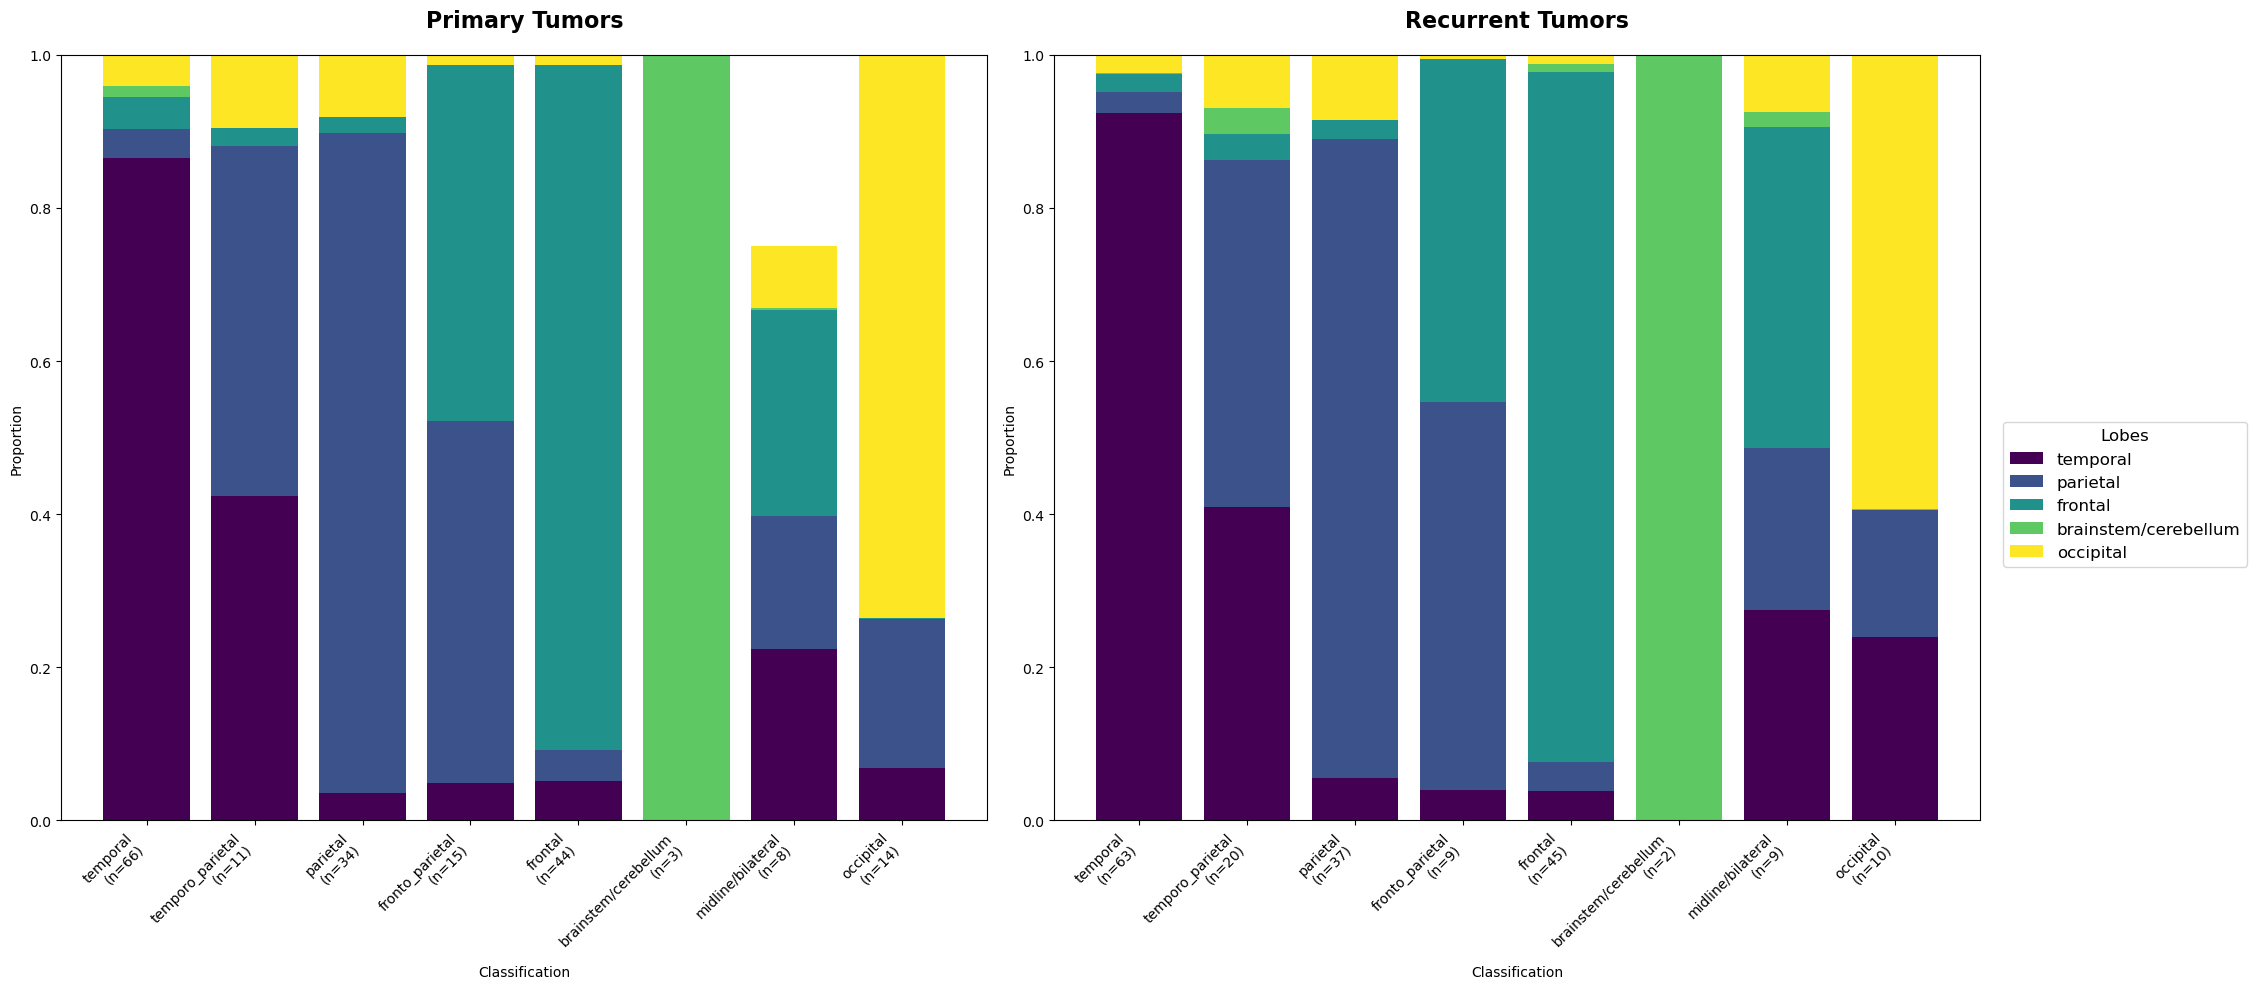


Detailed Statistics for Primary Tumors by Classification:

temporal (n=66):
Hemisphere distribution:
  Left: 37 cases
  Right: 29 cases
Lobe involvement:
  temporal: 86.6%

temporo_parietal (n=11):
Hemisphere distribution:
  Left: 7 cases
  Right: 4 cases
Lobe involvement:
  temporal: 42.4%
  parietal: 45.7%
  occipital: 9.6%

parietal (n=34):
Hemisphere distribution:
  Left: 17 cases
  Right: 17 cases
Lobe involvement:
  parietal: 86.3%
  occipital: 8.1%

fronto_parietal (n=15):
Hemisphere distribution:
  Right: 8 cases
  Left: 7 cases
Lobe involvement:
  parietal: 47.3%
  frontal: 46.5%

frontal (n=44):
Hemisphere distribution:
  Left: 28 cases
  Right: 16 cases
Lobe involvement:
  temporal: 5.2%
  frontal: 89.5%

brainstem/cerebellum (n=3):
Hemisphere distribution:
  brainstem/cerebellum: 3 cases
Lobe involvement:
  brainstem/cerebellum: 100.0%

midline/bilateral (n=8):
Hemisphere distribution:
  midline/bilateral: 8 cases
Lobe involvement:
  temporal: 22.4%
  parietal: 17.4%
  fro

In [34]:
def calculate_lobe_proportions(df: pd.DataFrame, tumor_type: str) -> pd.DataFrame:
    """
    Calculate lobe proportions for each case
    """
    proportions = pd.DataFrame(index=df.index)
    
    # Calculate total volume and proportions for each lobe
    for case_idx in df.index:
        total_volume = 0
        volumes = {}
        
        # Calculate volumes for each lobe (combining hemispheres)
        for lobe in ['temporal', 'parietal', 'frontal', 'occipital']:
            left_vol = df.loc[case_idx, f'OVL_{lobe}_left_CE_core_{tumor_type}']
            right_vol = df.loc[case_idx, f'OVL_{lobe}_right_CE_core_{tumor_type}']
            volumes[lobe] = left_vol + right_vol
            total_volume += volumes[lobe]
        
        # Add brainstem volume
        brainstem_vol = df.loc[case_idx, f'OVL_brainstem_and_cerebellum_CE_core_{tumor_type}']
        volumes['brainstem/cerebellum'] = brainstem_vol
        total_volume += brainstem_vol
        
        # Convert to proportions
        if total_volume > 0:
            for lobe, volume in volumes.items():
                proportions.loc[case_idx, lobe] = volume / total_volume
        else:
            for lobe in volumes.keys():
                proportions.loc[case_idx, lobe] = 0
    
    return proportions

def plot_lobe_distribution(results: dict, tumor_type: str, ax: plt.Axes, classification_order: list, df: pd.DataFrame):
    """
    Create a stacked bar chart showing the distribution of lobe involvement for each classification
    """
    # Define the preferred lobe order
    lobe_order = [
        'temporal',
        'parietal',
        'frontal',
        'brainstem/cerebellum',
        'occipital'
    ]
    
    # Get the data
    classifications = results['classifications']
    raw_proportions = calculate_lobe_proportions(df, tumor_type)
    
    # Initialize the bottom of each bar to 0
    bottom = np.zeros(len(classification_order))
    
    # Get viridis colormap colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(lobe_order)))
    
    # Function to get base classification
    def get_base_classification(class_str):
        if pd.isna(class_str):
            return 'undefined'
        if class_str == 'midline/bilateral':
            return 'midline/bilateral'
        if class_str == 'brainstem/cerebellum':
            return 'brainstem/cerebellum'
        parts = class_str.split('_')
        if len(parts) < 2:
            return class_str
        if 'temporo_parietal' in class_str:
            return 'temporo_parietal'
        elif 'fronto_parietal' in class_str:
            return 'fronto_parietal'
        else:
            return parts[-1]
    
    # Plot each lobe's contribution
    for lobe, color in zip(lobe_order, colors):
        means = []
        for class_name in classification_order:
            # Get mask for all classifications matching this base type
            base_classifications = classifications.apply(get_base_classification)
            mask = base_classifications == class_name
            means.append(raw_proportions[mask][lobe].mean() if mask.any() else 0)
        
        ax.bar(classification_order, means, bottom=bottom, label=lobe, color=color)
        bottom += means
    
    # Customize the plot
    ax.set_title(f'{tumor_type} Tumors', pad=20, fontsize=16, fontweight='bold')
    ax.set_xlabel('Classification')
    ax.set_ylabel('Proportion')
    
    # Add counts to the x-axis labels
    base_classifications = classifications.apply(get_base_classification)
    counts = base_classifications.value_counts()
    new_labels = [f'{label}\n(n={counts[label] if label in counts else 0})' for label in classification_order]
    ax.set_xticks(range(len(classification_order)))
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

def run_complete_analysis(df: pd.DataFrame) -> Dict:
    """Run complete analysis for both primary and recurrent tumors"""
    # Define base classification order
    classification_order = [
        'temporal',
        'temporo_parietal',
        'parietal',
        'fronto_parietal',
        'frontal',
        'brainstem/cerebellum',
        'midline/bilateral',
        'occipital'
    ]
    
    classifier = EnhancedTumorLocationClassifier(df)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Analyze both tumor types
    results = {}
    for i, tumor_type in enumerate(['Primary', 'Recurrent']):
        type_results = classifier.classify_locations(tumor_type)
        results[tumor_type.lower()] = type_results
        
        # Create the lobe distribution plot
        plot_lobe_distribution(type_results, tumor_type, ax1 if i == 0 else ax2, classification_order, df)
    
    # Add legend
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, title='Lobes', 
              bbox_to_anchor=(1.0, 0.5), loc='center left', 
              fontsize='large', title_fontsize='large')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    def get_base_classification(class_str):
        if pd.isna(class_str):
            return 'undefined'
        if class_str == 'midline/bilateral':
            return 'midline/bilateral'
        if class_str == 'brainstem/cerebellum':
            return 'brainstem/cerebellum'
        parts = class_str.split('_')
        if len(parts) < 2:
            return class_str
        if 'temporo_parietal' in class_str:
            return 'temporo_parietal'
        elif 'fronto_parietal' in class_str:
            return 'fronto_parietal'
        else:
            return parts[-1]
    
    for tumor_type in ['Primary', 'Recurrent']:
        type_results = results[tumor_type.lower()]
        classifications = type_results['classifications']
        raw_proportions = calculate_lobe_proportions(df, tumor_type)
        
        # Group by base classification
        base_classifications = classifications.apply(get_base_classification)
        counts = base_classifications.value_counts()
        
        print(f"\nDetailed Statistics for {tumor_type} Tumors by Classification:")
        for class_name in classification_order:
            if class_name in counts:
                print(f"\n{class_name} (n={counts[class_name]}):")
                mask = base_classifications == class_name
                class_props = raw_proportions[mask].mean()
                
                # Print hemisphere distribution
                hem_dist = classifications[mask].str.split('_').str[0].value_counts()
                print("Hemisphere distribution:")
                for hem, count in hem_dist.items():
                    print(f"  {hem}: {count} cases")
                
                # Print lobe involvement
                print("Lobe involvement:")
                for lobe, prop in class_props.items():
                    if prop >= 0.05:
                        print(f"  {lobe}: {prop:.1%}")
    
    return results


results = run_complete_analysis(df_total)